In [ ]:
!pip install keras


In [16]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [17]:
#importing required libraries
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense,Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt




In [18]:
#load data
(x_train,y_train),(x_test,y_test)=mnist.load_data()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)



(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [19]:
# normalisation
x_train=x_train/255
x_test=x_test/255

In [20]:
img_width=x_train.shape[1]
img_height=x_train.shape[2]
num_channels=1 # as grayscale

# reshaping into 60000,28,28,1 and 10000,28,28,1
x_train=x_train.reshape(x_train.shape[0],img_height,img_width,num_channels)
x_test=x_test.reshape(x_test.shape[0],img_height,img_width,num_channels)
input_shape=(img_height,img_width,num_channels)




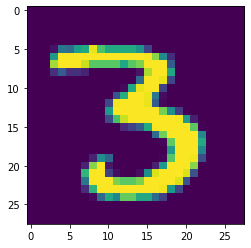

In [21]:
plt.imshow(x_train[12][:,:,0])

In [22]:
# build model

latent_dim=2 # number of latent dim parameters

input_img=Input(shape=input_shape,name='encoder-i/p')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

# shape of conv to be given to decoder
conv_shape=K.int_shape(x)

# flatten
x=Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, for latent mean and std. deviation
# These are used to sample random variables in latent space to which inputs are mapped. 
z_mu = Dense(latent_dim, name='latent_mu')(x)   # Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  # Std dev. (variance) of encoded input

In [23]:
# reparameterizing function
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

In [24]:
# sampling the latent vector from the distribution
z=Lambda(sample_z,output_shape=(latent_dim,),name='z')([z_mu,z_sigma])

# Z(lambda layer) is the last layer of the encoder
encoder=Model(input_img,[z_mu,z_sigma,z],name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder-i/p (InputLayer)        [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 32)   320         encoder-i/p[0][0]                
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_9[0][0]                   
____________________________________________________________________________________________

In [25]:
# building the decoder

decoder_input = Input(shape=(latent_dim,),name='decoder_input')
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

z_decoded = decoder(z)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


In [26]:
# define loss layer
# reconstruction loss and KL divergence
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
    
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)

        return K.mean(recon_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomLayer()([input_img, z_decoded])

In [27]:
# training the model
vae = Model(input_img, y, name='vae')

vae.compile(optimizer='adam', loss=None)
vae.summary()

vae.fit(x_train, None, epochs = 10, batch_size = 32, validation_split = 0.2)

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder-i/p (InputLayer)        [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 32)   320         encoder-i/p[0][0]                
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_9[0][0]                   
________________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


48000/48000 [==============================] - 222s 5ms/sample - loss: 0.2346 - val_loss: 0.2086
Epoch 2/10
48000/48000 [==============================] - 219s 5ms/sample - loss: 0.2030 - val_loss: 0.1986
Epoch 3/10
48000/48000 [==============================] - 221s 5ms/sample - loss: 0.1962 - val_loss: 0.1938
Epoch 4/10
48000/48000 [==============================] - 221s 5ms/sample - loss: 0.1924 - val_loss: 0.1907
Epoch 5/10
48000/48000 [==============================] - 221s 5ms/sample - loss: 0.1902 - val_loss: 0.1887
Epoch 6/10
48000/48000 [==============================] - 222s 5ms/sample - loss: 0.1884 - val_loss: 0.1879
Epoch 7/10
48000/48000 [==============================] - 223s 5ms/sample - loss: 0.1871 - val_loss: 0.1877
Epoch 8/10
48000/48000 [==============================] - 224s 5ms/sample - loss: 0.1862 - val_loss: 0.1856
Epoch 9/10
48000/48000 [==============================] - 224s 5ms/sample - loss: 0.1852 - val_loss: 0.1855
Epoch 10/10
48000/48000 [==============

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


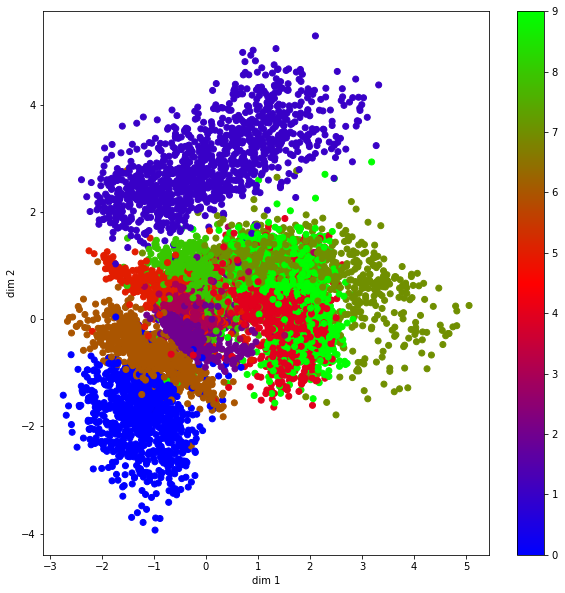

In [28]:
mu, _, _ = encoder.predict(x_test)
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

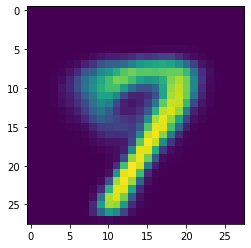

In [31]:
sample_vector = np.array([[1,1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


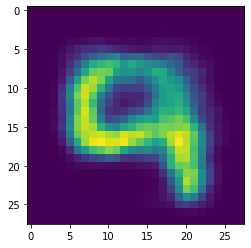

In [29]:
sample_vector = np.array([[1,-1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

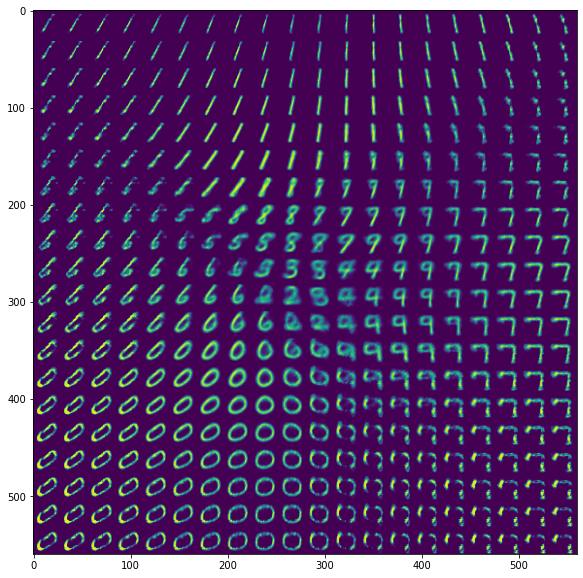

In [34]:
n = 20  
figure = np.zeros((img_width * n, img_height * n, num_channels))

grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))

fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure)
plt.show()  